In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 4 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,XSS,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,NaN,200 OK,text/html; charset=utf-8,22,NaN,200,text/html; charset=utf-8,"""Windows""",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,NaN,200 OK,application/json,41,NaN,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,Log Forging,401 UNAUTHORIZED,application/json,41,NaN,401,"{""error"": ""Not a number failed to parse""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,NaN,200 OK,application/json,871,NaN,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,NaN,NaN,NaN


In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,XSS,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,200 OK,text/html; charset=utf-8,22,NaN,200,text/html; charset=utf-8,"""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,NaN,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,401 UNAUTHORIZED,application/json,41,NaN,401,"{""error"": ""Not a number failed to parse""}",NaN,NaN,NaN,NaN,NaN,Log Forging,Malware
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,200 OK,application/json,871,NaN,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182762,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,"en-US,en;q=0.5",none,same-origin,max-age=0,?1,document,['ttauth=vDA_pRaPgv5BX9UlIvE2-G5JEBJe4PvEXroOv...,"Sun, 18 Dec 2022 01:37:37 GMT",GET,http://127.0.0.1:5000/categories/check/name/Pr...,,200 OK,application/json,101,NaN,200,"{""category_id"": ""7"", ""category_name"": ""Produce...","""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
182763,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,?1,de-CH,none,same-origin,no-cache,?1,document,['cid=YQAQXREK77h1CZXs6lAoKHvBgZfKuaV4aEMuONaI...,"Sun, 18 Dec 2022 01:20:52 GMT",GET,http://127.0.0.1:5000/login/user?username=Sowi...,,401 UNAUTHORIZED,application/json,26,NaN,401,"{""error"": ""Access denied""}","""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
182764,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['ck=Y0mqGJ92oxXkiQMuhlP3oypr6p0wBFCvveiuxxe-R...,"Sun, 18 Dec 2022 01:22:10 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fp%3E...,,302 FOUND,text/html; c

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,None,None,None,None,None,XSS,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,200 OK,text/html; charset=utf-8,22,None,200,text/html; charset=utf-8,"""Windows""",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,None,None,None,None,None,None,None,None,None,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,None,200,"{""message"": ""Welcome to the Book Store!""}",None,None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,401 UNAUTHORIZED,application/json,41,None,401,"{""error"": ""Not a number failed to parse""}",None,None,None,None,None,Log Forging,Malware
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,200 OK,application/json,871,None,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,None,None,None,Benign,Benign


In [4]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,0,0.000000,1,0,0,?0,2,1,1,no-store,0,1,-0.359211,0,0.577350,2,-1.0,0.0,302,-1.000000,None,-1.0,-1.0,-1.0,None,XSS,Malware
1,0,0.500000,1,0,0,?0,3,1,2,no-store,0,1,-0.861640,0,1.000000,0,-1.0,-1.0,200,-1.000000,"""Windows""",-1.0,-1.0,-1.0,None,Benign,Benign
2,0,0.577350,0,0,0,None,0,0,0,None,1,0,-1.000000,0,0.707107,0,-1.0,-1.0,200,0.000000,None,-1.0,-1.0,-1.0,None,Benign,Benign
3,0,-0.816497,1,0,0,?0,1,1,2,max-age=0,0,1,-0.426401,0,0.000000,4,-1.0,-1.0,401,0.408248,None,-1.0,-1.0,-1.0,None,Log Forging,Malware
4,0,0.632456,631,0,0,?1,2,1,2,max-age=0,0,1,-0.880451,1,0.377964,0,-1.0,-1.0,200,-0.255551,"""Windows""",-1.0,-1.0,-1.0,None,Benign,Benign


In [5]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182767 entries, 0 to 182766
Data columns (total 27 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   request.headers.Host                       182767 non-null  int32  
 1   request.headers.User-Agent                 182767 non-null  float64
 2   request.headers.Accept-Encoding            182767 non-null  int32  
 3   request.headers.Accept                     182767 non-null  int32  
 4   request.headers.Connection                 182767 non-null  int32  
 5   request.headers.Sec-Ch-Ua-Mobile           182767 non-null  object 
 6   request.headers.Accept-Language            182767 non-null  int32  
 7   request.headers.Sec-Fetch-Site             182767 non-null  int32  
 8   request.headers.Sec-Fetch-Mode             182767 non-null  int32  
 9   request.headers.Cache-Control              182767 non-null  object 
 10  request.

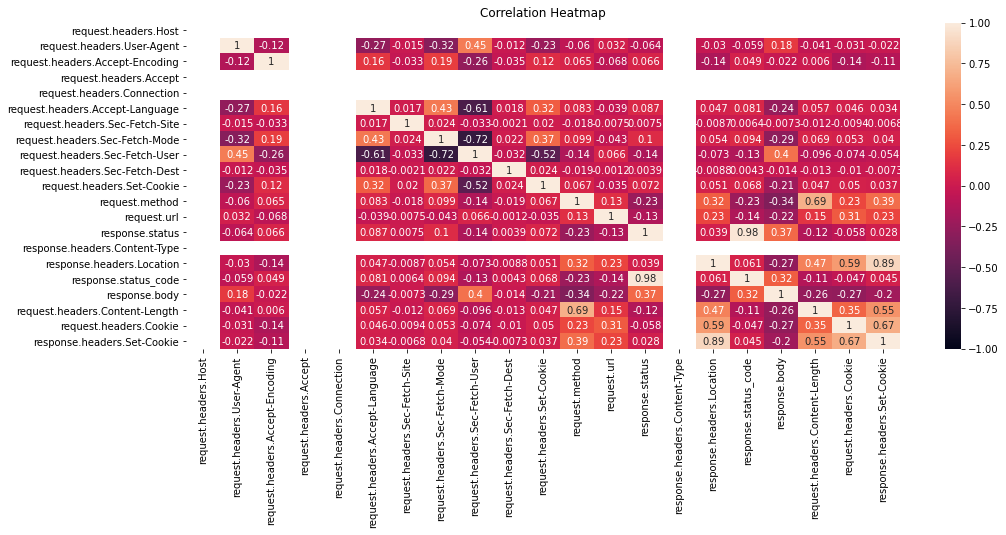

In [6]:

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

In [7]:
#drop

# Check which fields don't matter

In [ ]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

# Train test split

In [ ]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

# Model choosing and fitting

## Random Forest

In [ ]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=70)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nBase = GaussianNB()
nBase.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = nBase.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## KNN

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = knn.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Ridge

In [ ]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=0.5).fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ridge.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Ada boost

In [ ]:

from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=660)
ada.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ada.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)],
                            n_jobs = -1) 
stack.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

In [ ]:

# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = stack.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## hard voting

In [ ]:
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)], voting='hard')
vot.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## soft voting

In [ ]:
vot_soft = VotingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)], voting='soft')
vot_soft.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot_soft.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Validation

In [ ]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

df.head()

In [ ]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

In [ ]:
df = vectorize_df(df)
df.head()

In [ ]:
#drops

In [ ]:
# # Choose the right features
# # In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

# features_list = df.columns.to_list()
# features_list.remove('label')
# features_list.remove('attack_type')
# print(features_list)

# # Recheck all datatype before training to see we don't have any objects in our features
# # In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
# df.dtypes

In [ ]:
val = df[features_list].to_numpy()

sns.set(rc={'figure.figsize':(15,8)})
prediction = vot.predict(val)
print(prediction)

In [ ]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(prediction), fmt='%2d')